### Ship ML Experiment
Predict gross tonnage of a ship! 

The approach can be divided into a few parts:
1. Explore the dataset and prepare the data 
2. Create new features 
3. Separate the data into train, validation and test set
4. Test feature importance 
5. Find correct algorithm and Hyperparameter tuning
7. Test the algorithm 



### But first: import all necessary packages for the start of this ML project!
Some packages will be installed later, when necessary 

In [428]:

import pandas as pd 
import numpy as np 
from matplotlib import pyplot

import sklearn as sk
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR  

from scipy.stats import uniform, truncnorm, randint
from pprint import pprint

## Part 1a: explore the dataset 
First I explore the dataset a bit. Although the set is small and column names and the number of rows can be seen immediately, I also get numeric values, type of the columns etc. Useful information for manual creation of features. 

I read in the data as a pandas dataframe. A dataframe allows for easy data exploration and data handling (column deletion, insertion etc.)

In [429]:
data = pd.read_csv("ship_data.csv", skiprows= 0)
data.head

<bound method NDFrame.head of        Ship_name Cruise_line  Age  cabins   crew  passengers  length  \
0        Journey     Azamara    6    3.55   3.55        6.94    5.94   
1          Quest     Azamara    6    3.55   3.55        6.94    5.94   
2    Celebration    Carnival   26    7.43   6.70       14.86    7.22   
3       Conquest    Carnival   11   14.88  19.10       29.74    9.53   
4        Destiny    Carnival   17   13.21  10.00       26.42    8.92   
..           ...         ...  ...     ...    ...         ...     ...   
153       Taurus        Star   22    0.33   0.59        0.66    2.79   
154        Virgo        Star   14    9.67  12.00       19.60    8.79   
155       Spirit    Windstar   25    0.74   0.88        1.58    4.40   
156         Star    Windstar   27    0.74   0.88        1.67    4.40   
157         Surf    Windstar   23    1.56   1.80        3.08    6.17   

     passenger_density  gross_tonnage  
0                42.64         30.277  
1                42.64   

In [430]:
# Check for null values 
data[data.isnull().any(axis=1)]


,Ship_name,Cruise_line,Age,cabins,crew,passengers,length,passenger_density,gross_tonnage


In [431]:
# Column names 
data.columns

Index(['Ship_name', 'Cruise_line', 'Age', 'cabins', 'crew', 'passengers',
       'length', 'passenger_density', 'gross_tonnage'],
      dtype='object')

In [432]:
# Information on number of columns, column types, number of rows
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Cruise_line        158 non-null    object 
 2   Age                158 non-null    int64  
 3   cabins             158 non-null    float64
 4   crew               158 non-null    float64
 5   passengers         158 non-null    float64
 6   length             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   gross_tonnage      158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


In [433]:
# More information in numbers of the numeric columns. 'Name' is excluded 
data.describe()

,Age,cabins,crew,passengers,length,passenger_density,gross_tonnage
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,8.830000,7.794177,18.457405,8.130633,39.900949,71.284671
std,7.615691,4.471417,3.503487,9.677095,1.793474,8.639217,37.229540
min,4.000000,0.330000,0.590000,0.660000,2.790000,17.700000,2.329000
25%,10.000000,6.132500,5.480000,12.535000,7.100000,34.570000,46.013000
50%,14.000000,9.570000,8.150000,19.500000,8.555000,39.085000,71.899000
75%,20.000000,10.885000,9.990000,24.845000,9.510000,44.185000,90.772500
max,48.000000,27.000000,21.000000,54.000000,11.820000,71.430000,220.000000


Additional information with help from the internet:
- Lenght is in foot (roughly 0.3 meters) x 100
- Number of passengers is x 100
- Number of crew is x 100
- Number of cabins is x 10 
- Passenger density the number of people per tonnage (so actually just passengers x passenger density = gross_tonnage?)
- Gross tonnage is x 100 

## Part 1b: prepare the data 
Before I'll split into train, validation and test set, I have to prepare some features. As we can see in the data, there are numeric features as well as object features. 

One of the features is the name of the ship. Assuming the name is not of importance to the prediction of the gross tonnage, we can leave this feature out of the data. 

Another feature is the "Cruise_line". This might be an important feature, but we do not know that now. 

In [434]:
data = data.drop(columns = ['Ship_name']).copy()

In [435]:
data["Cruise_line"].unique()
len(data["Cruise_line"].unique()) 

20

There are 20 unique values for "Cruise_line". I will make this categorical using Label Encoding. This makes it easier for the model to handle, however it will lose some form of meaning. 

In [436]:
data['Cruise_line'] = data.Cruise_line.astype('category').cat.codes


In [437]:
data.head

<bound method NDFrame.head of      Cruise_line  Age  cabins   crew  passengers  length  passenger_density  \
0              0    6    3.55   3.55        6.94    5.94              42.64   
1              0    6    3.55   3.55        6.94    5.94              42.64   
2              1   26    7.43   6.70       14.86    7.22              31.80   
3              1   11   14.88  19.10       29.74    9.53              36.99   
4              1   17   13.21  10.00       26.42    8.92              38.36   
..           ...  ...     ...    ...         ...     ...                ...   
153           18   22    0.33   0.59        0.66    2.79              50.62   
154           18   14    9.67  12.00       19.60    8.79              39.18   
155           19   25    0.74   0.88        1.58    4.40              33.86   
156           19   27    0.74   0.88        1.67    4.40              32.04   
157           19   23    1.56   1.80        3.08    6.17              47.87   

     gross_tonnage  


In [438]:
# Get X and y to start with 
X = data.drop(columns = ['gross_tonnage']).copy()
y = data['gross_tonnage']

## Part 2: Create new features
As we expect and will see later, some of the features in the dataset are important for prediction of the gross tonnage, while other features are not. 

To make better predictions based on features, combinations of existing features might be predictors of the gross tonnage as well. 

Manually engineering features to improve the prediction power of the models:
- Passenger per cabin  
- Cabins per length 
- Passengers per length
- Total number of people by adding crew and passengers 


In [439]:
# Passenger per cabin 
# Cabins x 10
# Passengers x 100
# Length is in foot? Foot = 0.3 meter x 100
for i in range(158):
    X["passenger_per_cabin"] = X["cabins"] / (X["passengers"] / 10)
    X["length_per_cabin"] = X["cabins"] / X["length"]
    X["passengers_per_length"] = X["length"] / X["passengers"]
    X["total_people"] = X["crew"] + X["passengers"]

X

,Cruise_line,Age,cabins,crew,passengers,length,passenger_density,passenger_per_cabin,length_per_cabin,passengers_per_length,total_people
0,0,6,3.55,3.55,6.94,5.94,42.64,5.115274,0.597643,0.855908,10.49
1,0,6,3.55,3.55,6.94,5.94,42.64,5.115274,0.597643,0.855908,10.49
2,1,26,7.43,6.70,14.86,7.22,31.80,5.000000,1.029086,0.485868,21.56
3,1,11,14.88,19.10,29.74,9.53,36.99,5.003362,1.561385,0.320444,48.84
4,1,17,13.21,10.00,26.42,8.92,38.36,5.000000,1.480942,0.337623,36.42
...,...,...,...,...,...,...,...,...,...,...,...
153,18,22,0.33,0.59,0.66,2.79,50.62,5.000000,0.118280,4.227273,1.25
154,18,14,9.67,12.00,19.60,8.79,39.18,4.933673,1.100114,0.448469,31.60
155,19,25,0.74,0.88,1.58,4.40,33.86,4.683544,0.168182,2.784810,2.46
156,19,27,0.74,0.88,1.67,4.40,32.04,4.431138,0.168182,2.634731,2.55


In [440]:
X.columns

Index(['Cruise_line', 'Age', 'cabins', 'crew', 'passengers', 'length',
       'passenger_density', 'passenger_per_cabin', 'length_per_cabin',
       'passengers_per_length', 'total_people'],
      dtype='object')

## Part 3: split into train, validation and test set
Train and test split as the usual practice, and addition of the validation set for the hyperparameter tuning. I opted for a small validation and test set, as the dataset has only 157 rows with data. 

Even though not completely necessary in a notebook, I've created a small function to return train, val and test set easily. 


In [441]:
def getTrainValTest(X, y, train_part, val_part):

    X_train, X_rest, y_train, y_rest = train_test_split(X,y, train_size=train_part)

    test_part = 1 - train_part - val_part

    X_val, X_test, y_val, y_test = train_test_split(X_rest,y_rest, test_size=test_part)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [442]:
X_train, y_train, X_val, y_val, X_test, y_test = getTrainValTest(X,y, 0.8, 0.1)

## Part 4: find feature importance 
From the given list of columns, not all features will be equally important. Keeping all features might result in overfitting, which is why some features are not taken into account for the training of the classifier. 

First we try to get a baseline with 2 different models by using all features and then use a function to calculate their feature importance.

I opted for Linear regression, Random Forests and Support Vector Machines to get a quick and dirty indication of the possibly important features. 

In [443]:
feat_names = ['Cruise_line', 'Age', 'cabins', 'crew', 'passengers', 'length',
       'passenger_density', 'passenger_per_cabin', 'length_per_cabin',
       'passengers_per_length', 'total_people']

Feature: 0, Cruise_line, Score: -0.08153597032678046
Feature: 1, Age, Score: -0.13990352757561997
Feature: 2, cabins, Score: 29.227455273591403
Feature: 3, crew, Score: 0.45289034246256216
Feature: 4, passengers, Score: 6.0537270474315905
Feature: 5, length, Score: 6.405016645152856
Feature: 6, passenger_density, Score: 7.7475345227384915
Feature: 7, passenger_per_cabin, Score: -3.355270812823001
Feature: 8, length_per_cabin, Score: -7.924985634890979
Feature: 9, passengers_per_length, Score: -0.46554998025682154
Feature: 10, total_people, Score: 4.637252378005719


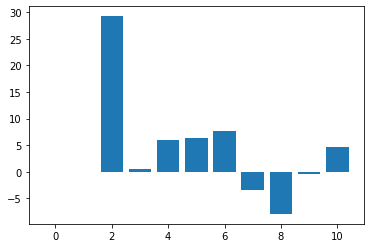

In [445]:
model = LinearRegression()

model.fit(scaled_X_train, y_train)

importance = model.coef_

for i,v in enumerate(importance):
	print('Feature: {0}, {1}, Score: {2}'.format(i, feat_names[i],v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

From this we can see that feature 2,4 and 8 are important, as they get more diverse coefficients 

Feature: 0, Cruise_line, Score: 0.001957429530390167
Feature: 1, Age, Score: 0.008331502040303638
Feature: 2, cabins, Score: 0.11946768333647682
Feature: 3, crew, Score: 0.07753549336933994
Feature: 4, passengers, Score: 0.04234413296149899
Feature: 5, length, Score: 0.548151947334715
Feature: 6, passenger_density, Score: 0.0018958152029483481
Feature: 7, passenger_per_cabin, Score: 0.0005941871046002057
Feature: 8, length_per_cabin, Score: 0.03116595724297178
Feature: 9, passengers_per_length, Score: 0.009327081621226693
Feature: 10, total_people, Score: 0.15922877025552853


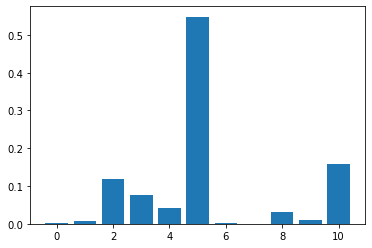

In [446]:
model = RandomForestRegressor()

model.fit(X_train, y_train)
importance = model.feature_importances_

for i,v in enumerate(importance):
	print('Feature: {0}, {1}, Score: {2}'.format(i, feat_names[i],v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

- Feature 2: cabins
- Feature 5: length 
- Feature 10: total_people
These feature using a RF seem to have the highest feature importance. Passenger_per_cabin and passenger_density seem to have the lowest feature importance 

Feature: 0, Cruise_line, Score: 0.000471551502763576
Feature: 1, Age, Score: 0.006331724643692781
Feature: 2, cabins, Score: 0.010147763027296341
Feature: 3, crew, Score: 0.1087123949153283
Feature: 4, passengers, Score: 0.006044392207455657
Feature: 5, length, Score: 0.7260497970958009
Feature: 6, passenger_density, Score: 0.004786830551394513
Feature: 7, passenger_per_cabin, Score: 0.00012112896863000247
Feature: 8, length_per_cabin, Score: 0.02555757731243623
Feature: 9, passengers_per_length, Score: 0.010797082322028353
Feature: 10, total_people, Score: 0.10097975745317349


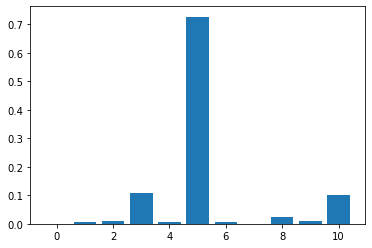

In [447]:
model = GradientBoostingRegressor()

model.fit(X_train, y_train)
importance = model.feature_importances_

for i,v in enumerate(importance):
	print('Feature: {0}, {1}, Score: {2}'.format(i, feat_names[i],v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In the case of the GB, feature 4, 5 and 10 are important, which are "passengers, "length" and "total_people". 

So the features that we need to watch are "cabins", "length", as well as a feature that includes people (crew, passengers)

####NOTE: 
It is actually quite interesting, because passenger_density * passengers gives gross tonnage, which is why I've expected that passengers and passenger_density both had higher feature importances. 

####Features: to stay or to go?
As the name of the ship does not really matter for the classification (well, maybe it does after extensive search of keywords?), we can leave out this column. A similar thing can be said about Age. 

We try automatic selection of features using a Linear Regression classifier as baseline.  Instead of the test set, we use the validation set. 

In [448]:
def select_features(X_train, y_train, X_val, number):
	# configure to select a subset of features
	fs = SelectKBest(score_func=f_regression, k=number)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_val_fs = fs.transform(X_val)
	return X_train_fs, X_val_fs, fs

In [449]:
print("Linear Regression")

for i in range(1, 12):

	X_train_fs, X_val_fs, fs = select_features(X_train, y_train, X_val, i)

	model = LinearRegression()
	model.fit(X_train_fs, y_train)

	yhat = model.predict(X_val_fs)

	# Get the names of the features
	filter = fs.get_support()
	features = X_train.columns

	print("Best features are for number ", i, " are: ", features[filter])
	rmse = mean_squared_error(y_val, yhat, squared=False)
	print('RMSE: %.3f' % rmse)


Linear Regression
Best features are for number  1  are:  Index(['total_people'], dtype='object')
RMSE: 10.009
Best features are for number  2  are:  Index(['cabins', 'total_people'], dtype='object')
RMSE: 10.169
Best features are for number  3  are:  Index(['cabins', 'passengers', 'total_people'], dtype='object')
RMSE: 9.879
Best features are for number  4  are:  Index(['cabins', 'crew', 'passengers', 'total_people'], dtype='object')
RMSE: 9.879
Best features are for number  5  are:  Index(['cabins', 'crew', 'passengers', 'length', 'total_people'], dtype='object')
RMSE: 8.407
Best features are for number  6  are:  Index(['cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'total_people'],
      dtype='object')
RMSE: 5.240
Best features are for number  7  are:  Index(['Age', 'cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'total_people'],
      dtype='object')
RMSE: 5.118
Best features are for number  8  are:  Index(['Age', 'cabins', 'crew', 'passen

Best performance LR: 10 features 

In [450]:
print("Random Forest")

for i in range(1, 12):

	X_train_fs, X_val_fs, fs = select_features(X_train, y_train, X_val, i)

	model = RandomForestRegressor()
	model.fit(X_train_fs, y_train)

	yhat = model.predict(X_val_fs)

	# Get the names of the features
	filter = fs.get_support()
	features = X_train.columns

	print("Best features are for number ", i, " are: ", features[filter])
	rmse = mean_squared_error(y_val, yhat, squared=False)
	print('RMSE: %.3f' % rmse)



Random Forest
Best features are for number  1  are:  Index(['total_people'], dtype='object')
RMSE: 8.832
Best features are for number  2  are:  Index(['cabins', 'total_people'], dtype='object')
RMSE: 7.047
Best features are for number  3  are:  Index(['cabins', 'passengers', 'total_people'], dtype='object')
RMSE: 6.659
Best features are for number  4  are:  Index(['cabins', 'crew', 'passengers', 'total_people'], dtype='object')
RMSE: 7.736
Best features are for number  5  are:  Index(['cabins', 'crew', 'passengers', 'length', 'total_people'], dtype='object')
RMSE: 5.002
Best features are for number  6  are:  Index(['cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'total_people'],
      dtype='object')
RMSE: 5.697
Best features are for number  7  are:  Index(['Age', 'cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'total_people'],
      dtype='object')
RMSE: 4.872
Best features are for number  8  are:  Index(['Age', 'cabins', 'crew', 'passengers',

Best performance RF: 7 features, followed by 6 features

In [451]:
print("Gradient Boosting")

for i in range(1, 12):

	X_train_fs, X_val_fs, fs = select_features(X_train, y_train, X_val, i)

	model = GradientBoostingRegressor()
	model.fit(X_train_fs, y_train)

	yhat = model.predict(X_val_fs)

	# Get the names of the features
	filter = fs.get_support()
	features = X_train.columns

	print("Best features are for number ", i, " are: ", features[filter])
	rmse = mean_squared_error(y_val, yhat, squared=False)
	print('RMSE: %.3f' % rmse)

Gradient Boosting
Best features are for number  1  are:  Index(['total_people'], dtype='object')
RMSE: 9.089
Best features are for number  2  are:  Index(['cabins', 'total_people'], dtype='object')
RMSE: 7.418
Best features are for number  3  are:  Index(['cabins', 'passengers', 'total_people'], dtype='object')
RMSE: 6.546
Best features are for number  4  are:  Index(['cabins', 'crew', 'passengers', 'total_people'], dtype='object')
RMSE: 7.762
Best features are for number  5  are:  Index(['cabins', 'crew', 'passengers', 'length', 'total_people'], dtype='object')
RMSE: 4.568
Best features are for number  6  are:  Index(['cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'total_people'],
      dtype='object')
RMSE: 5.139
Best features are for number  7  are:  Index(['Age', 'cabins', 'crew', 'passengers', 'length', 'length_per_cabin',
       'total_people'],
      dtype='object')
RMSE: 4.819
Best features are for number  8  are:  Index(['Age', 'cabins', 'crew', 'passenge

Best performance GB: 4 features, followed by 11 features. 

So all models perform better with a different subset of features. RF and GB with a lower number of features, LR with a higher number of features. 

### Manual subset testing
To explore the features further, I tried manual feature combinations. 

- Exclude Age and Cruiseline
- Exclude passenger_per_length and passengers
- Exclude crew and length_per_cabin 

I tried these removals. The first one I based on the earlier investigation using the importance of the models tried. The last four are features that were already embedded in other features (passengers and crew can be found in total_people) and they also scored low on the feature importance. 


In [452]:
# Baseline

print("Linear regression")
# Linear Regression 
model = LinearRegression()
model.fit(X_train, y_train)

yhat = model.predict(X_val)

mae = mean_absolute_error(y_val, yhat)
r2 = r2_score(y_val, yhat)
rmse = mean_squared_error(y_val, yhat, squared=False)
print('MAE LR: %.3f' % mae)
print('R2 LR: %.3f' % r2)
print('RMSE LR: %.3f' % rmse)

print("Random forest")
# Random Forest
model2 = RandomForestRegressor()
model2.fit(X_train, y_train)

yhat2 = model2.predict(X_val)

mae2 = mean_absolute_error(y_val, yhat2)
r2_2 = r2_score(y_val, yhat2)
rmse2 = mean_squared_error(y_val, yhat2, squared = False)
print('MAE RF: %.3f' % mae2)
print('R2 RF: %.3f' % r2_2)
print('RMSE RF: %.3f' % rmse2)

# Gradient Boosting 
print("Gradient Boosting")
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

yhat_gb= reg.predict(X_val)

mae_gb = mean_absolute_error(y_val, yhat_gb)
r2_gb = r2_score(y_val, yhat_gb)
rmse_gb = mean_squared_error(y_val, yhat_gb, squared = False)
print('MAE GB: %.3f' % mae_gb)
print('R2 GB: %.3f' % r2_gb)
print('RMSE GB: %.3f' % rmse_gb)


Linear regression
MAE LR: 4.687
R2 LR: 0.931
RMSE LR: 7.462
Random forest
MAE RF: 3.406
R2 RF: 0.972
RMSE RF: 4.757
Gradient Boosting
MAE GB: 2.551
R2 GB: 0.980
RMSE GB: 3.977


In [453]:
# Exclude Age and Cruiseline 
subset_X_train = X_train[['cabins', 'crew', 'passengers', 'length',
       'passenger_density', 'passenger_per_cabin', 'length_per_cabin',
       'passengers_per_length', 'total_people']]
    
subset_X_val = X_val[['cabins', 'crew', 'passengers', 'length',
       'passenger_density', 'passenger_per_cabin', 'length_per_cabin',
       'passengers_per_length', 'total_people']]

In [454]:
# Exclude age and cruiseline
# Linear Regression 
print('Linear Regression')
modelsub = LinearRegression()
modelsub.fit(subset_X_train, y_train)

yhat_sub = modelsub.predict(subset_X_val)

mae_sub = mean_absolute_error(y_val, yhat_sub)
r2_sub = r2_score(y_val, yhat)
rmse_sub = mean_squared_error(y_val, yhat_sub, squared=False)
print('MAE LR_sub: %.3f' % mae_sub)
print('R2 LR_sub: %.3f' % r2_sub)
print('RMSE LR_sub: %.3f' % rmse_sub)

# Random Forest
print("Random Forest")
model2_sub = RandomForestRegressor()
model2_sub.fit(subset_X_train, y_train)

yhat2_sub = model2_sub.predict(subset_X_val)

mae2_sub = mean_absolute_error(y_val, yhat2_sub)
r2_2_sub = r2_score(y_val, yhat2_sub)
rmse2_sub = mean_squared_error(y_val, yhat2_sub, squared = False)
print('MAE RF_sub: %.3f' % mae2_sub)
print('R2 RF_sub: %.3f' % r2_2_sub)
print('RMSE RF_sub: %.3f' % rmse2_sub)

# gradient boosting 
print("Gradient boosting")
reg_sub = GradientBoostingRegressor(random_state=0)
reg_sub.fit(subset_X_train, y_train)

yhat_gb_sub= reg_sub.predict(subset_X_val)

mae_gb_sub = mean_absolute_error(y_val, yhat_gb_sub)
r2_gb_sub = r2_score(y_val, yhat_gb_sub)
rmse_gb_sub = mean_squared_error(y_val, yhat_gb_sub, squared = False)
print('MAE GB_sub: %.3f' % mae_gb_sub)
print('R2 GB_sub: %.3f' % r2_gb_sub)
print('RMSE GB_sub: %.3f' % rmse_gb_sub)

Linear Regression
MAE LR_sub: 4.746
R2 LR_sub: 0.931
RMSE LR_sub: 7.545
Random Forest
MAE RF_sub: 3.344
R2 RF_sub: 0.970
RMSE RF_sub: 4.919
Gradient boosting
MAE GB_sub: 1.942
R2 GB_sub: 0.988
RMSE GB_sub: 3.109


In [455]:
# Exclude passenger_per_cabin and crew 
subset_X_train = X_train[['cabins', 'passengers', 'length',
       'passenger_density', 'length_per_cabin',
       'passengers_per_length', 'total_people']]
    
subset_X_val = X_val[['cabins' , 'passengers', 'length',
       'passenger_density','length_per_cabin',
       'passengers_per_length', 'total_people']]

In [456]:
# Exclude passenger_per_cabin and crew 
# Linear Regression 
print('Linear Regression')

modelsub = LinearRegression()
modelsub.fit(subset_X_train, y_train)

yhat_sub = modelsub.predict(subset_X_val)

mae_sub = mean_absolute_error(y_val, yhat_sub)
r2_sub = r2_score(y_val, yhat)
rmse_sub = mean_squared_error(y_val, yhat_sub, squared=False)
print('MAE LR_sub: %.3f' % mae_sub)
print('R2 LR_sub: %.3f' % r2_sub)
print('RMSE LR_sub: %.3f' % rmse_sub)

# Random Forest
print("Random Forest")

model2_sub = RandomForestRegressor()
model2_sub.fit(subset_X_train, y_train)

yhat2_sub = model2_sub.predict(subset_X_val)

mae2_sub = mean_absolute_error(y_val, yhat2_sub)
r2_2_sub = r2_score(y_val, yhat2_sub)
rmse2_sub = mean_squared_error(y_val, yhat2_sub, squared = False)
print('MAE RF_sub: %.3f' % mae2_sub)
print('R2 RF_sub: %.3f' % r2_2_sub)
print('RMSE RF_sub: %.3f' % rmse2_sub)

# gradient boosting 
print("Gradient boosting")
reg_sub = GradientBoostingRegressor(random_state=0)
reg_sub.fit(subset_X_train, y_train)

yhat_gb_sub= reg_sub.predict(subset_X_val)

mae_gb_sub = mean_absolute_error(y_val, yhat_gb_sub)
r2_gb_sub = r2_score(y_val, yhat_gb_sub)
rmse_gb_sub = mean_squared_error(y_val, yhat_gb_sub, squared = False)
print('MAE GB_sub: %.3f' % mae_gb_sub)
print('R2 GB_sub: %.3f' % r2_gb_sub)
print('RMSE GB_sub: %.3f' % rmse_gb_sub)

Linear Regression
MAE LR_sub: 3.954
R2 LR_sub: 0.931
RMSE LR_sub: 6.104
Random Forest
MAE RF_sub: 3.376
R2 RF_sub: 0.968
RMSE RF_sub: 5.080
Gradient boosting
MAE GB_sub: 2.420
R2 GB_sub: 0.981
RMSE GB_sub: 3.860


In [457]:
# Exclude passenger_per_length and passengers
subset_X_train = X_train[['cabins',  'length', 'passenger_density',
        'length_per_cabin', 'total_people']]
    
subset_X_val = X_val[['cabins' ,  'length', 'passenger_density',
       'length_per_cabin', 'total_people']]

In [458]:
# Exclude passenger per length and passengers
# Linear Regression 
print('Linear Regression')

modelsub = LinearRegression()
modelsub.fit(subset_X_train, y_train)

yhat_sub = modelsub.predict(subset_X_val)

mae_sub = mean_absolute_error(y_val, yhat_sub)
r2_sub = r2_score(y_val, yhat)
rmse_sub = mean_squared_error(y_val, yhat_sub, squared=False)
print('MAE LR_sub: %.3f' % mae_sub)
print('R2 LR_sub: %.3f' % r2_sub)
print('RMSE LR_sub: %.3f' % rmse_sub)

# Random Forest
print("Random Forest")

model2_sub = RandomForestRegressor()
model2_sub.fit(subset_X_train, y_train)

yhat2_sub = model2_sub.predict(subset_X_val)

mae2_sub = mean_absolute_error(y_val, yhat2_sub)
r2_2_sub = r2_score(y_val, yhat2_sub)
rmse2_sub = mean_squared_error(y_val, yhat2_sub, squared = False)
print('MAE RF_sub: %.3f' % mae2_sub)
print('R2 RF_sub: %.3f' % r2_2_sub)
print('RMSE RF_sub: %.3f' % rmse2_sub)

# gradient boosting 
print("Gradient boosting")
reg_sub = GradientBoostingRegressor(random_state=0)
reg_sub.fit(subset_X_train, y_train)

yhat_gb_sub= reg_sub.predict(subset_X_val)

mae_gb_sub = mean_absolute_error(y_val, yhat_gb_sub)
r2_gb_sub = r2_score(y_val, yhat_gb_sub)
rmse_gb_sub = mean_squared_error(y_val, yhat_gb_sub, squared = False)
print('MAE GB_sub: %.3f' % mae_gb_sub)
print('R2 GB_sub: %.3f' % r2_gb_sub)
print('RMSE GB_sub: %.3f' % rmse_gb_sub)

Linear Regression
MAE LR_sub: 4.030
R2 LR_sub: 0.931
RMSE LR_sub: 5.690
Random Forest
MAE RF_sub: 3.455
R2 RF_sub: 0.963
RMSE RF_sub: 5.466
Gradient boosting
MAE GB_sub: 2.622
R2 GB_sub: 0.972
RMSE GB_sub: 4.749


After manual feature deletion, I have found that 5 features instead of 11 are sufficient for prediction: 'cabins',  'length', 'passenger_density', 'length_per_cabin', 'total_people'. I tried every exclusion of features with and without previously removed features. So for example, I tried inserting 'Cruise_line' and 'Age'  when I removed 'passenger_per_length'  and 'passengers'. This is my final verdict of important features: 3 already existing features and 2 manual features. 

As the dataset is not that large, I did not expect a large number of features. In comparison with the manual feature select of SelectKBest, other features are selected as most important for some algorithms. LR shows best performance using 10 features, GB using 4 features and RF using 6 features. I tried these features manually as well, but this shows a decrease in R2 score. As performance between the models differs and the optimal number of features differ as well using SelectKBest, I will keep the 5 manually selected features for the hyperparameter tuning of the final models as the performance seems to be better than with SelectKBest. It would be interesting to compare final performance with manual selected features vs. SelectKBest, but this would mean 3 x 2 hyperparameter tuning processes, so in this case I will keep it with the manual investigation and results. 

The feature passenger_density scored low in the earlier investigation of feature importance. But I tried removing this as well, but it does not work in combination with total_feature and removal of passengers. 


In [459]:
# Subset of X_train, X_val and X_test
subset_X_train = X_train[['cabins',  'length', 'passenger_density',
        'length_per_cabin', 'total_people']]
    
subset_X_val = X_val[['cabins' ,  'length', 'passenger_density',
       'length_per_cabin', 'total_people']]

subset_X_test = X_test[['cabins' ,  'length', 'passenger_density',
       'length_per_cabin', 'total_people']]


## Part 5: Choose algorithm for the regression task  and hyperparameter tuning
The algorithm of choice is determined by cross validation. The models compared are Linear Regression, Random Forests and Gradient Boosting. The baseline performance is the performance of the untuned models for the feature selection, shown underneath each model. I use the RandomizedSearchCV of sklearn, because this allows for K-Fold cross validation in a randomized way. It will select at random which values for the parameters will be sampled. 

### Linear regression 
As the data might be linear, Linear Regression would work fine by the KISS principle: keep it simple stupid. Why use a complex model that is more difficult to explain if we can also use a very simple model that is easy to interpret?

- MAE LR_sub: 3.899
- R2 LR_sub: 0.984
- RMSE LR_sub: 5.279

I found out that I cannot tune LR. I did not know this, but then the baseline is the final model. 

### Random Forests:
The Random Forest creates different Decision trees (ensemble of decision trees) and takes the average prediction. However, it cannot extrapolate, meaning that it is not able to obtain values outside ethe train set during prediction. It is not the best model when the data is linear. 

- MAE RF_sub: 4.625
- R2 RF_sub: 0.916
- RMSE RF_sub: 12.690

The parameters I will tune are:
- n_estimators: number of trees
- max_features: the max number of features that are considered for each split
- max_depth: maximum number of levels in a tree
- min_samples_split: the minimum number of data points necessary for a split
- min_samples_leaf: the minimum number of data points allowed in a leaf
- bootstrap: whether to sample the data points or use it all 

### Gradient Boosting:
The last model is Gradient boosting 

- MAE GB_sub: 4.613
- R2 GB_sub: 0.923
- RMSE GB_sub: 12.168

### Measurements
The model will be evaluated using Root Mean Squared Error and the R2 score. These metrics provide a baseline which we try to improve with hyperparameter tuning. 

In [460]:
lr = LinearRegression()
lr.fit(subset_X_train, y_train)

lr_yhat = lr.predict(subset_X_val)

r2_lr = r2_score(y_val, lr_yhat)
rmse_lr = mean_squared_error(y_val, lr_yhat, squared=False)
print('R2 LR: %.3f' % r2_lr)
print('RMSE LR: %.3f' % rmse_lr)


R2 LR: 0.960
RMSE LR: 5.690


In [461]:
# Random Forest tuning

rf = RandomForestRegressor()

rf_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt', 1,2,3,4,5],
               'min_samples_leaf': [1, 2, 3, 4, 8, 10, ],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [1,2,4,8,16,32,40, 50, 64,100, 120, 140, 150, 200]}

In [462]:
# Actual search

rf_search = RandomizedSearchCV(rf, rf_grid, n_iter=100, scoring = 'neg_root_mean_squared_error', cv=5)


In [463]:
# Fit the model to the train set 
rf_model = rf_search.fit(subset_X_train, y_train)

In [464]:
# Print the parameters 
pprint(rf_model.best_estimator_.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 60,
 'max_features': 4,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 4,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [465]:
# Test the model with the validation set 
rf_yhat = rf_model.predict(subset_X_val)

r2_rf = r2_score(y_val, rf_yhat)
rmse_rf = mean_squared_error(y_val, rf_yhat, squared = False)
print('R2 rf: %.3f' % r2_rf)
print('RMSE rf: %.3f' % rmse_rf)


R2 rf: 0.953
RMSE rf: 6.159


In [466]:
# GB tuning 

gb = GradientBoostingRegressor()

gb_grid = {
    'n_estimators':[5,50,100,250,500],
    'max_depth':[1,3,5,7,9],
    'learning_rate':[0.01,0.1,1],
    'min_samples_leaf': [1, 2, 3, 4, 8, 10],
    'min_samples_split': [2, 5, 8, 10],
    'max_features': ['auto', 'sqrt', 'log2', None, 1,2,3,4,5]
}

In [467]:
# Actual search 

gb_search = RandomizedSearchCV(gb, gb_grid, n_iter=100, scoring = 'neg_root_mean_squared_error', cv=5)


In [468]:
# Fit model to train set 
gb_model = gb_search.fit(subset_X_train, y_train)

/Users/sinievanderben/miniforge3/envs/ddg/lib/python3.10/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Users/sinievanderben/miniforge3/envs/ddg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sinievanderben/miniforge3/envs/ddg/lib/python3.10/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Users/sinievanderben/miniforge3/envs/ddg/lib/python3.10/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow encountered in square
  * np.sum(sample_weight * ((y - raw_predictions.ravel()) ** 2))
/Users/sinievanderben/miniforge3/envs/ddg/lib/python3.10/site-packages/sklearn/ensemble/_gb_losses.py:231: RuntimeWarning: overflow enco

In [469]:
# Print parameters
pprint(gb_model.best_estimator_.get_params())

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [470]:
# Test the model with the validation set

gb_yhat = gb_model.predict(subset_X_val)

r2_gb = r2_score(y_val, gb_yhat)
rmse_gb = mean_squared_error(y_val, gb_yhat, squared = False)
print('R2 rf: %.3f' % r2_gb)
print('RMSE rf: %.3f' % rmse_gb)

R2 rf: 0.980
RMSE rf: 3.996


## Part 7a: Testing per model

In [471]:
# Linear Regression
lr_yhat_test = lr.predict(subset_X_test)

r2_lr = r2_score(y_test, lr_yhat_test)
rmse_lr = mean_squared_error(y_test, lr_yhat_test, squared=False)
print('R2 LR: %.3f' % r2_lr)
print('RMSE LR: %.3f' % rmse_lr)

R2 LR: 0.956
RMSE LR: 5.169


In [472]:
# Random Forest

rf_yhat_test = rf_model.predict(subset_X_test)

r2_rf = r2_score(y_test, rf_yhat_test)
rmse_rf = mean_squared_error(y_test, rf_yhat_test, squared = False)
print('R2 rf: %.3f' % r2_rf)
print('RMSE rf: %.3f' % rmse_rf)

R2 rf: 0.914
RMSE rf: 7.258


In [473]:
# Gradient Boosting

gb_yhat_test = gb_model.predict(subset_X_test)

r2_gb = r2_score(y_test, gb_yhat_test)
rmse_gb = mean_squared_error(y_test, gb_yhat_test, squared = False)
print('R2 rf: %.3f' % r2_gb)
print('RMSE rf: %.3f' % rmse_gb)

R2 rf: 0.945
RMSE rf: 5.790


## Part 7b: compare with passengers * passenger_density 

As I went through the column names, I did not know what "passenger_density was". When I looked it up online, I got the feeling that (passenger * passenger_density) / 10 is the gross tonnage. I tried this for a few values in Excell, so I will make predictions using only these 2 and compare this against the test. 

In [474]:
y_manual_prediction = (X_test["passengers"] * X_test["passenger_density"])/10

r2_manual = r2_score(y_test, y_manual_prediction)
rmse_manual = mean_squared_error(y_test, y_manual_prediction, squared = False)

print(y_manual_prediction)
print(y_test)

print('RMSE manual: %.3f' % rmse_manual)

60     55.4508
46     51.0044
43    111.9860
71     59.0580
dtype: float64
60     55.451
46     51.004
43    112.000
71     59.058
Name: gross_tonnage, dtype: float64
RMSE manual: 0.007
